In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/kinematics_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [4]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [5]:
del feature_array, label_array

In [6]:
with np.load("root_files/kinematics_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [7]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [8]:
del feature_array_test, label_array_test

In [9]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [10]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 20)
(11734326, 20)
(1467277, 20)
(1467277, 20)


In [11]:
del bkg, sig, bkg_test, sig_test, df

In [12]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [13]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 20)
(1782913, 20)
(222732, 20)
(222732, 20)


  0%|          | 0/20 [00:00<?, ?it/s]

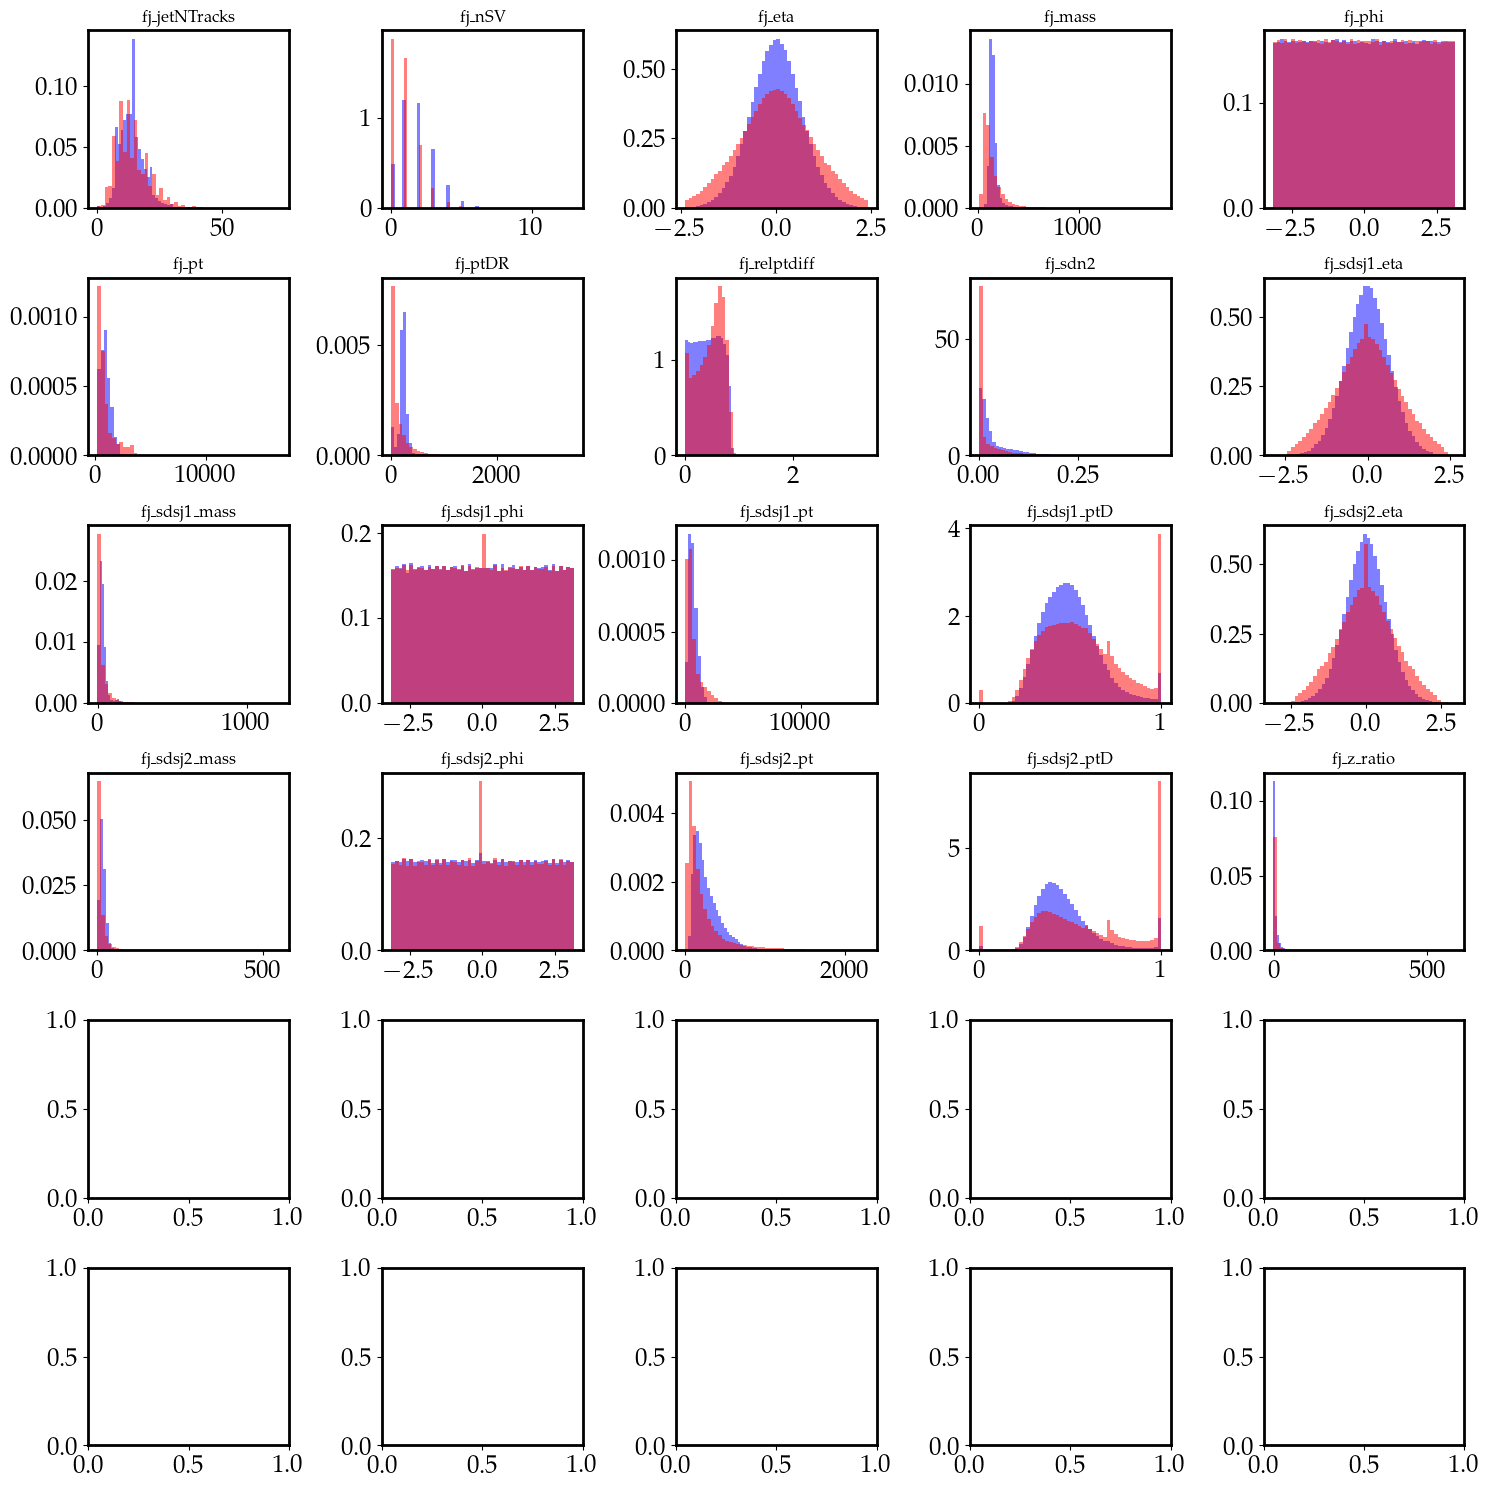

In [14]:
fig, axes = plt.subplots(6,5, figsize=(15,15))

for ax, label in tqdm(zip(axes.ravel(), sig_train_out.columns), total = 20):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

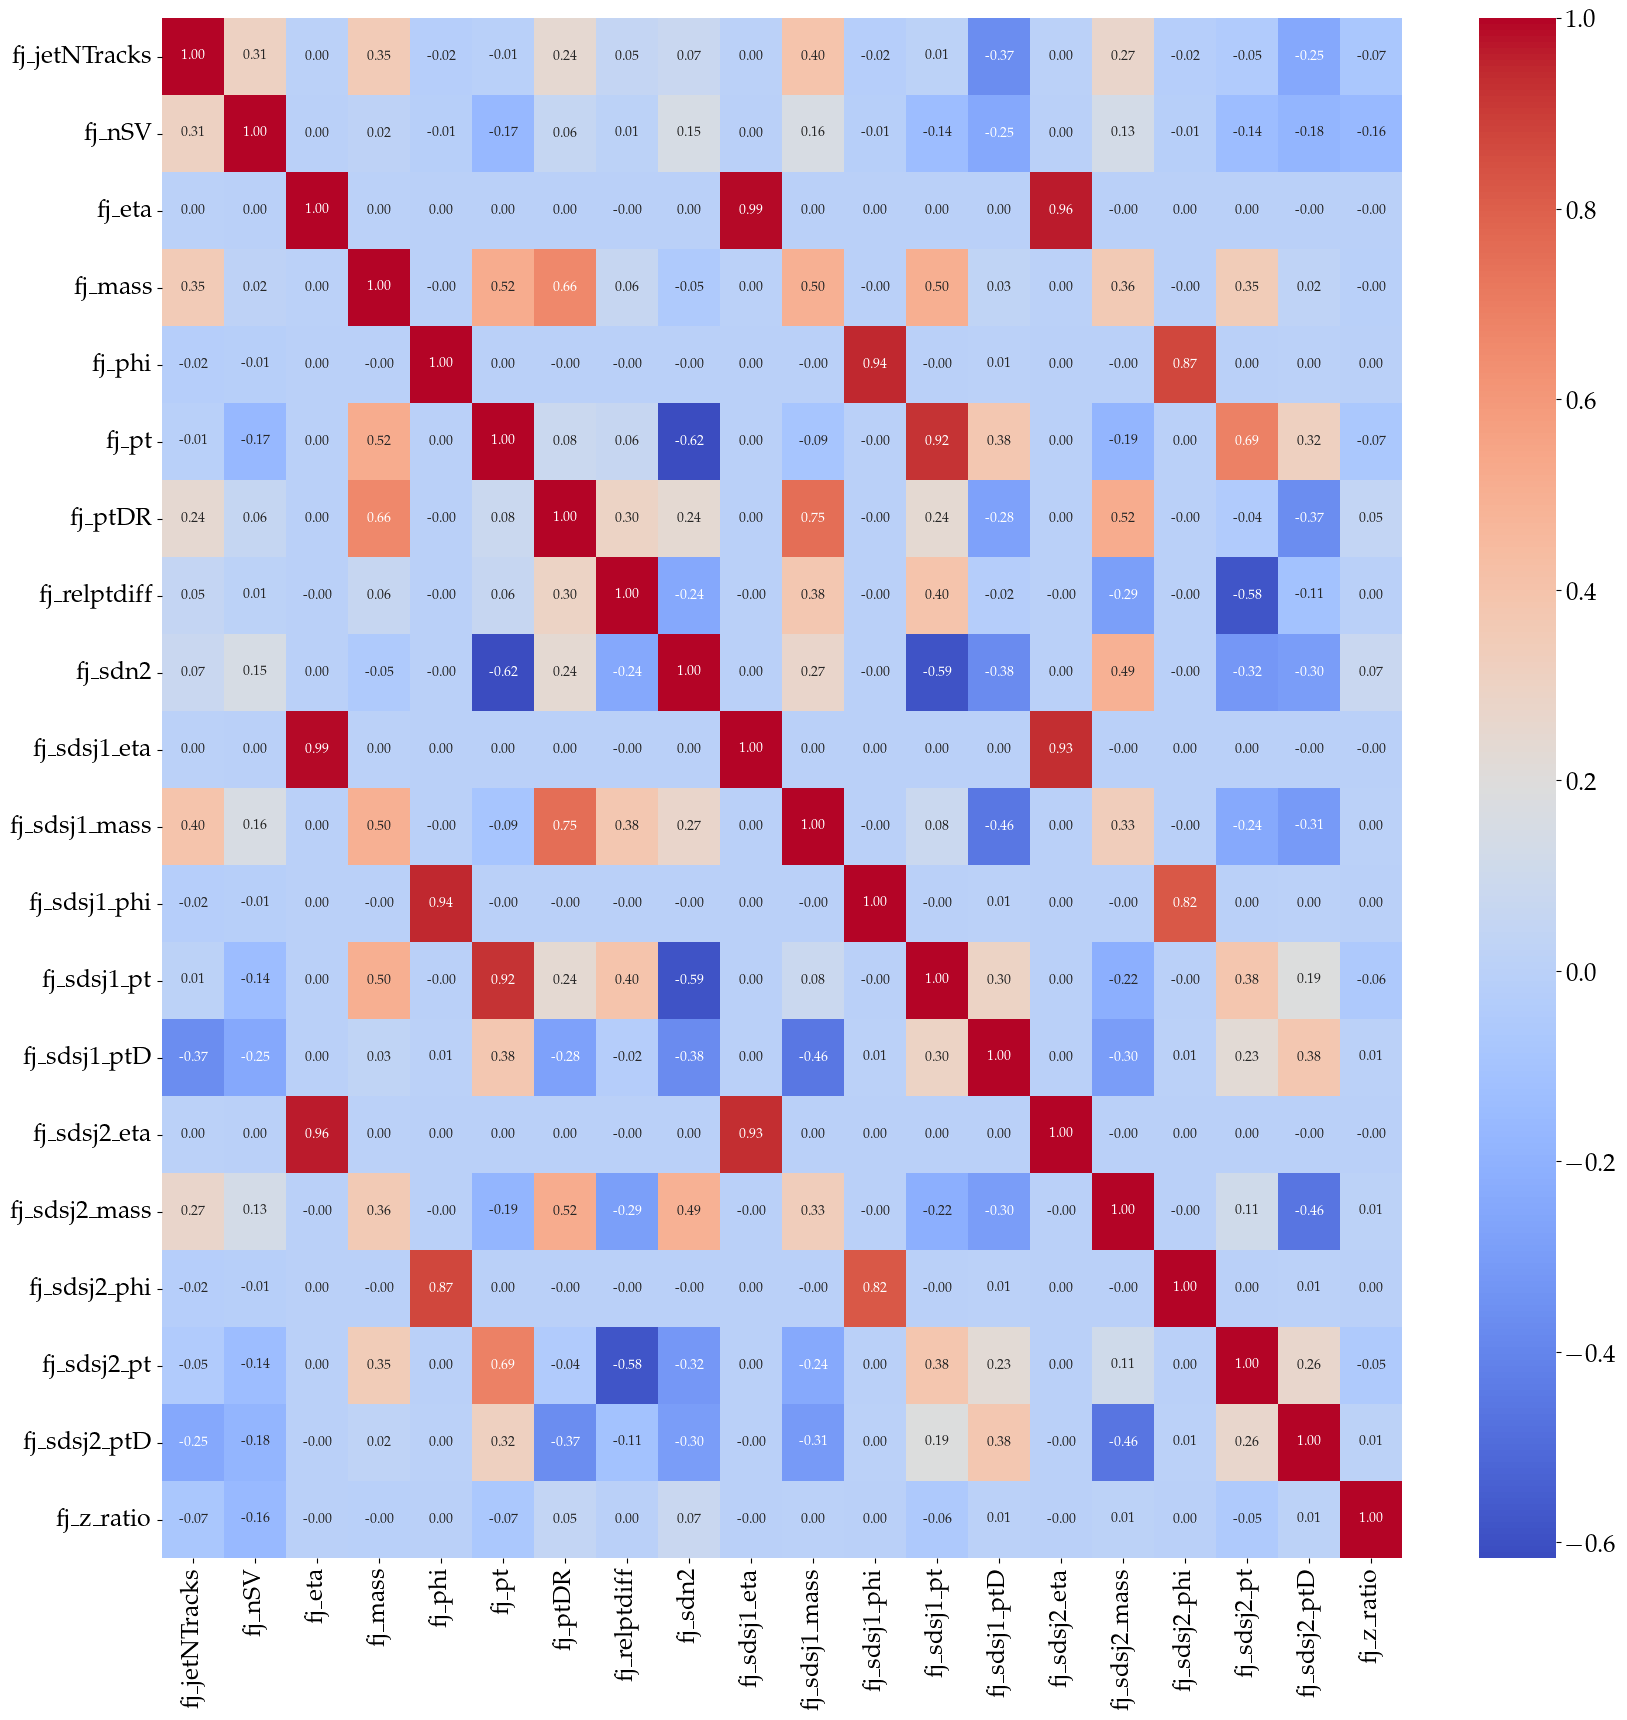

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

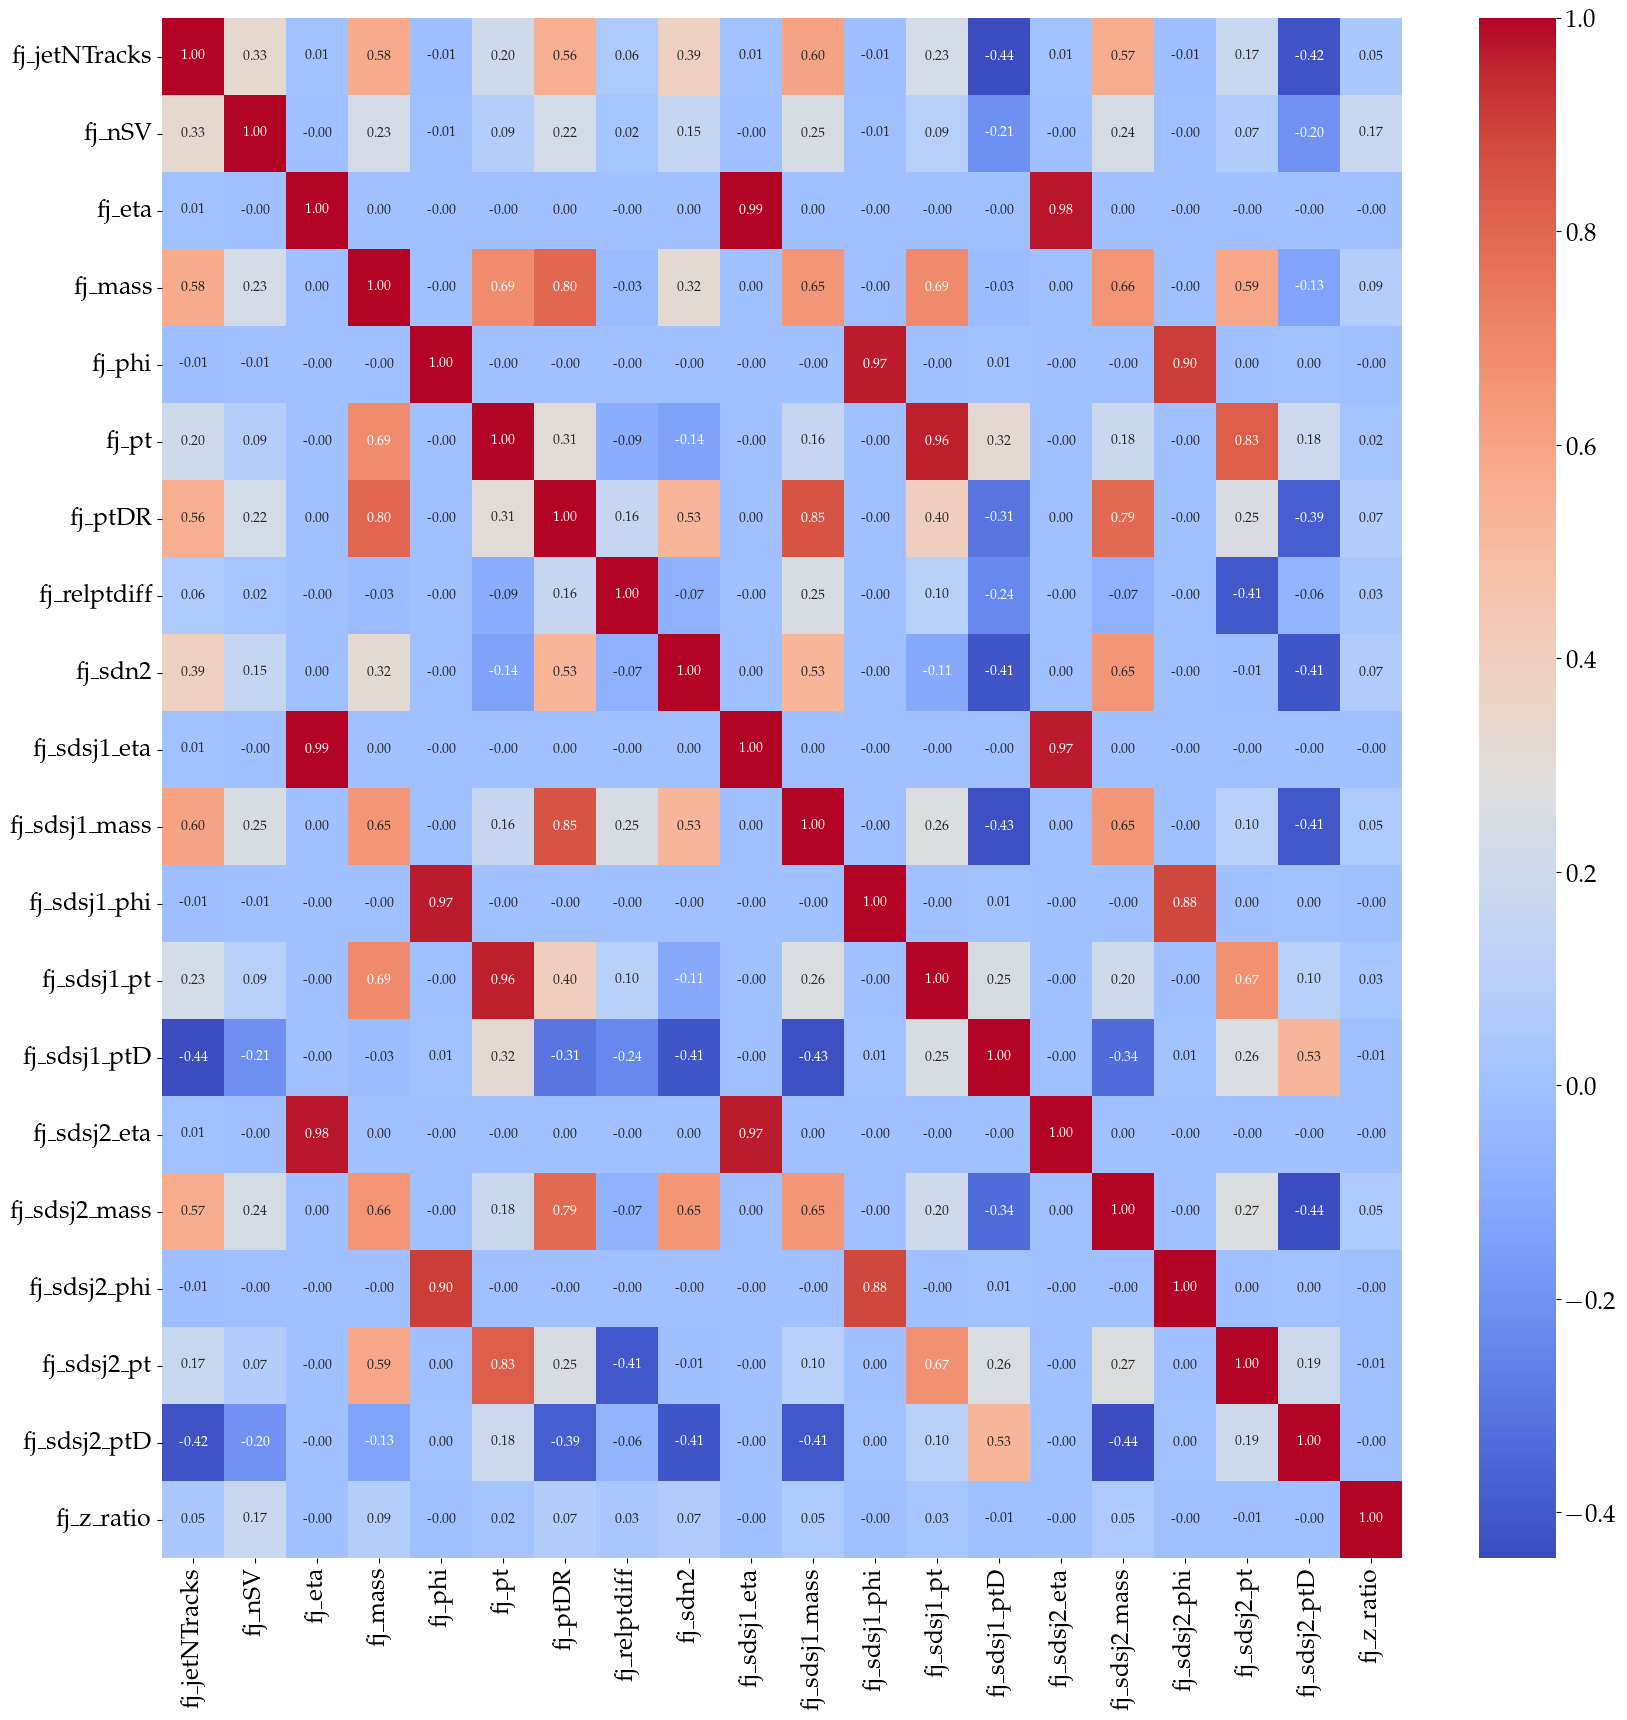

In [16]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

In [17]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [18]:
del traindata

In [19]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [20]:
del testdata

In [21]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 265 ms, sys: 118 ms, total: 383 ms
Wall time: 385 ms


In [22]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [23]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

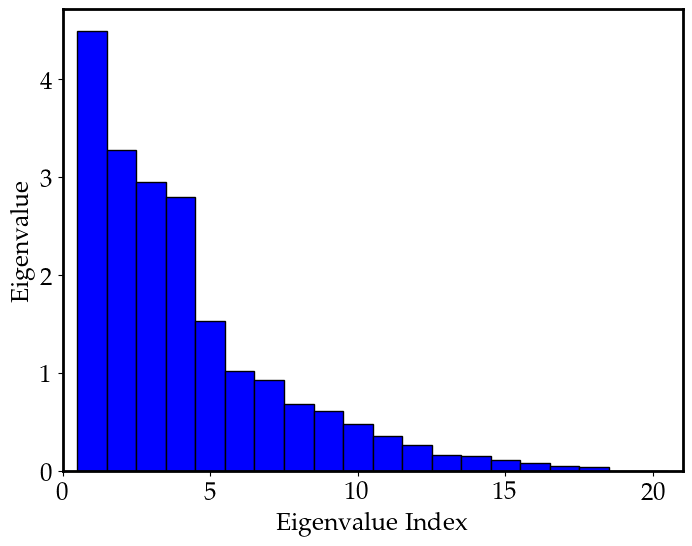

In [24]:
plt.figure(figsize=(8,6))
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [25]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[2.24541576e-01 1.63894851e-01 1.47365966e-01 1.39818611e-01
 7.66228010e-02 5.10892258e-02 4.65038162e-02 3.40775851e-02
 3.07996306e-02 2.37597262e-02 1.78855345e-02 1.33734486e-02
 8.14646802e-03 7.64153489e-03 5.58394989e-03 4.07178926e-03
 2.43352848e-03 2.02962183e-03 2.01119595e-04 1.59216029e-04]
[0.22454158 0.38843643 0.53580239 0.675621   0.75224381 0.80333303
 0.84983685 0.88391443 0.91471406 0.93847379 0.95635932 0.96973277
 0.97787924 0.98552077 0.99110472 0.99517651 0.99761004 0.99963966
 0.99984078 1.        ]
[4001.69011875 3418.83172931 3241.85562473 3157.7486843  2337.62091078
 1908.79694863 1821.12337346 1558.94027399 1482.06695826 1301.71463541
 1129.39544823  976.60012905  762.21896435  738.21926019  631.05298851
  538.87460494  416.59426601  380.45442058  119.76288918  106.5585899 ]
CPU times: user 3.72 s, sys: 1.22 s, total: 4.94 s
Wall time: 1.07 s


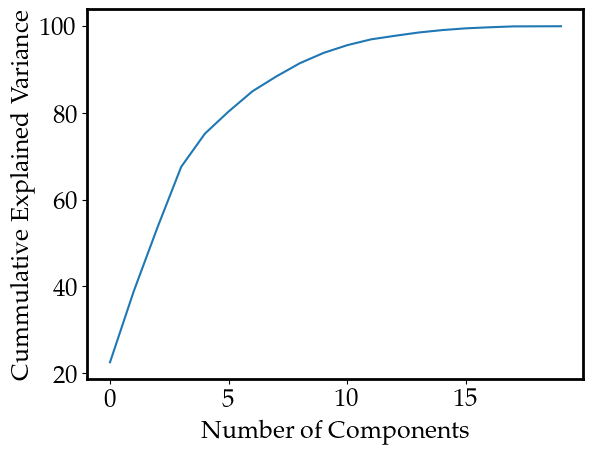

In [26]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [27]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [28]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/20 [00:00<?, ?it/s]

fj_mass          2.623677
fj_ptDR          2.332439
fj_sdsj2_mass    1.397011
fj_sdsj1_mass    1.157494
fj_sdsj2_pt      1.150899
fj_sdn2          1.072620
fj_pt            0.982889
fj_nSV           0.704188
fj_sdsj1_pt      0.676404
fj_sdsj2_ptD     0.564676
fj_sdsj1_ptD     0.297077
fj_eta           0.262219
fj_sdsj1_eta     0.261087
fj_sdsj2_eta     0.209109
fj_jetNTracks    0.181038
fj_relptdiff     0.069427
fj_z_ratio       0.041960
fj_sdsj2_phi     0.015339
fj_sdsj1_phi     0.002326
fj_phi           0.000227
dtype: float64


In [29]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [30]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [34]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(BatchNormalization(input_shape=(X_train_final.shape[1],)))
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 60)                1260      
                                                                 
 dense_7 (Dense)             (None, 60)                3660      
                                                                 
 dense_8 (Dense)             (None, 2)                 122       
                                                                 
Total params: 5,122
Trainable params: 5,082
Non-trainable params: 40
_________________________________________________________________
None


In [35]:
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6902 - accuracy: 0.5405
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6823 - accuracy: 0.5546
Epoch 3/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6752 - accuracy: 0.5689
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6686 - accuracy: 0.5826
Epoch 5/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6625 - accuracy: 0.5950
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6567 - accuracy: 0.6061
Epoch 7/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6513 - accuracy: 0.6162
Epoch 8/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6461 - accuracy: 0.6254
Epoch 9/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6411 - accuracy: 0.6342
Epoch 10/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6363 - accuracy: 0.6426
Epoch 1/1

55/55 [==============================] - 1s 14ms/step - loss: 0.6634 - accuracy: 0.5932
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6534 - accuracy: 0.6122
Epoch 5/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6443 - accuracy: 0.6285
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6358 - accuracy: 0.6434
Epoch 7/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6278 - accuracy: 0.6575
Epoch 8/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6203 - accuracy: 0.6712
Epoch 9/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6131 - accuracy: 0.6843
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6062 - accuracy: 0.6967
Epoch 1/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6868 - accuracy: 0.5465
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6732 - accuracy: 0.5730
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 14ms/step - loss: 0.6177 - accuracy: 0.6758
Epoch 6/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6055 - accuracy: 0.6978
Epoch 7/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5942 - accuracy: 0.7166
Epoch 8/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5834 - accuracy: 0.7318
Epoch 9/10
55/55 [==============================] - 1s 13ms/step - loss: 0.5733 - accuracy: 0.7440
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.5636 - accuracy: 0.7539
Epoch 1/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6818 - accuracy: 0.5561
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6604 - accuracy: 0.5988
Epoch 3/10
55/55 [==============================] - 1s 13ms/step - loss: 0.6428 - accuracy: 0.6309
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6275 - accuracy: 0.6581
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 12ms/step - loss: 0.5468 - accuracy: 0.7680
Epoch 8/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5319 - accuracy: 0.7783
Epoch 9/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5180 - accuracy: 0.7865
Epoch 10/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5048 - accuracy: 0.7934
Epoch 1/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6739 - accuracy: 0.5720
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6412 - accuracy: 0.6337
Epoch 3/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6157 - accuracy: 0.6795
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5937 - accuracy: 0.7170
Epoch 5/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5741 - accuracy: 0.7428
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5563 - accuracy: 0.7604
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 14ms/step - loss: 0.4464 - accuracy: 0.8189
Epoch 10/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4312 - accuracy: 0.8248
Epoch 1/10
55/55 [==============================] - 1s 14ms/step - loss: 0.6617 - accuracy: 0.5952
Epoch 2/10
55/55 [==============================] - 1s 14ms/step - loss: 0.6133 - accuracy: 0.6834
Epoch 3/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5769 - accuracy: 0.7390
Epoch 4/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5462 - accuracy: 0.7682
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5192 - accuracy: 0.7857
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4950 - accuracy: 0.7981
Epoch 7/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4733 - accuracy: 0.8077
Epoch 8/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4540 - accuracy: 0.8158
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 13ms/step - loss: 0.6437 - accuracy: 0.6281
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.5737 - accuracy: 0.7411
Epoch 3/10
55/55 [==============================] - 1s 13ms/step - loss: 0.5231 - accuracy: 0.7832
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.4818 - accuracy: 0.8040
Epoch 5/10
55/55 [==============================] - 1s 13ms/step - loss: 0.4479 - accuracy: 0.8182
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4208 - accuracy: 0.8287
Epoch 7/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3996 - accuracy: 0.8363
Epoch 8/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3832 - accuracy: 0.8419
Epoch 9/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3703 - accuracy: 0.8460
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3601 - accuracy: 0.8492
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 13ms/step - loss: 0.4530 - accuracy: 0.8161
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.4078 - accuracy: 0.8334
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3786 - accuracy: 0.8434
Epoch 6/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3594 - accuracy: 0.8494
Epoch 7/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3462 - accuracy: 0.8535
Epoch 8/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3367 - accuracy: 0.8565
Epoch 9/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3293 - accuracy: 0.8588
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3235 - accuracy: 0.8607
Epoch 1/10
55/55 [==============================] - 1s 12ms/step - loss: 0.6135 - accuracy: 0.6776
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.5109 - accuracy: 0.7892
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 13ms/step - loss: 0.3341 - accuracy: 0.8573
Epoch 6/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3230 - accuracy: 0.8609
Epoch 7/10
55/55 [==============================] - 1s 12ms/step - loss: 0.3151 - accuracy: 0.8636
Epoch 8/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3088 - accuracy: 0.8659
Epoch 9/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3038 - accuracy: 0.8678
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2996 - accuracy: 0.8694
Epoch 1/10
55/55 [==============================] - 1s 13ms/step - loss: 0.5750 - accuracy: 0.7218
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.4397 - accuracy: 0.8211
Epoch 3/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3757 - accuracy: 0.8442
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.3461 - accuracy: 0.8535
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 14ms/step - loss: 0.2938 - accuracy: 0.8717
Epoch 8/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2895 - accuracy: 0.8735
Epoch 9/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2861 - accuracy: 0.8751
Epoch 10/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2832 - accuracy: 0.8763
Epoch 1/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5234 - accuracy: 0.7607
Epoch 2/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3739 - accuracy: 0.8447
Epoch 3/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3324 - accuracy: 0.8578
Epoch 4/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3150 - accuracy: 0.8637
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3043 - accuracy: 0.8676
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2969 - accuracy: 0.8704
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 14ms/step - loss: 0.2727 - accuracy: 0.8813
Epoch 10/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2702 - accuracy: 0.8825
Epoch 1/10
55/55 [==============================] - 1s 12ms/step - loss: 0.4646 - accuracy: 0.7939
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3314 - accuracy: 0.8582
Epoch 3/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3060 - accuracy: 0.8670
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2938 - accuracy: 0.8717
Epoch 5/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2865 - accuracy: 0.8749
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2814 - accuracy: 0.8772
Epoch 7/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2773 - accuracy: 0.8791
Epoch 8/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2740 - accuracy: 0.8806
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 14ms/step - loss: 0.4117 - accuracy: 0.8189
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3054 - accuracy: 0.8672
Epoch 3/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2887 - accuracy: 0.8738
Epoch 4/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2811 - accuracy: 0.8773
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2805 - accuracy: 0.8776
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2748 - accuracy: 0.8805
Epoch 7/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2689 - accuracy: 0.8833
Epoch 8/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2660 - accuracy: 0.8847
Epoch 9/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2656 - accuracy: 0.8849
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2634 - accuracy: 0.8861
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 13ms/step - loss: 0.2848 - accuracy: 0.8750
Epoch 4/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2699 - accuracy: 0.8823
Epoch 5/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2693 - accuracy: 0.8829
Epoch 6/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2649 - accuracy: 0.8852
Epoch 7/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2605 - accuracy: 0.8875
Epoch 8/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2613 - accuracy: 0.8877
Epoch 9/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2508 - accuracy: 0.8926
Epoch 10/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2566 - accuracy: 0.8897
Epoch 1/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3876 - accuracy: 0.8250
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2943 - accuracy: 0.8707
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 12ms/step - loss: 0.2694 - accuracy: 0.8832
Epoch 6/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2594 - accuracy: 0.8883
Epoch 7/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2615 - accuracy: 0.8874
Epoch 8/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2531 - accuracy: 0.8915
Epoch 9/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2557 - accuracy: 0.8904
Epoch 10/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2489 - accuracy: 0.8936
Epoch 1/10
55/55 [==============================] - 1s 13ms/step - loss: 0.3876 - accuracy: 0.8205
Epoch 2/10
55/55 [==============================] - 1s 13ms/step - loss: 0.2889 - accuracy: 0.8723
Epoch 3/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2828 - accuracy: 0.8759
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2686 - accuracy: 0.8832
Epoch 5/10
55/55 [==

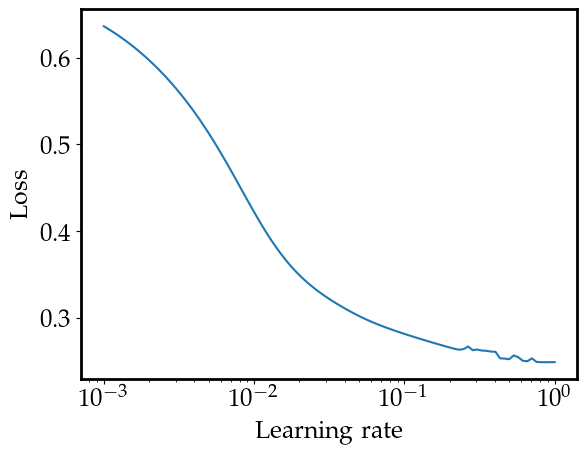

In [36]:
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.show()

In [37]:
lr = rates[np.nanargmin(losses)]
print(lr)

0.8697490026177834


In [38]:
%%time
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, 
                          epochs=100, shuffle=False, callbacks = callbacks, 
                          validation_data=(X_test_final,y_test))

Epoch 1/100
55/55 [==============================] - 1s 22ms/step - loss: 0.3838 - accuracy: 0.8198 - val_loss: 0.3213 - val_accuracy: 0.8606
Epoch 2/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2904 - accuracy: 0.8717 - val_loss: 0.2738 - val_accuracy: 0.8795
Epoch 3/100
55/55 [==============================] - 1s 13ms/step - loss: 0.2806 - accuracy: 0.8768 - val_loss: 0.2851 - val_accuracy: 0.8763
Epoch 4/100
55/55 [==============================] - 1s 15ms/step - loss: 0.2693 - accuracy: 0.8827 - val_loss: 0.2577 - val_accuracy: 0.8887
Epoch 5/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2694 - accuracy: 0.8830 - val_loss: 0.2684 - val_accuracy: 0.8842
Epoch 6/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2595 - accuracy: 0.8881 - val_loss: 0.2500 - val_accuracy: 0.8933
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2613 - accuracy: 0.8873 - val_loss: 0.2624 - val_accuracy: 0.8874
Epoch 

55/55 [==============================] - 1s 14ms/step - loss: 0.2303 - accuracy: 0.9027 - val_loss: 0.2283 - val_accuracy: 0.9037
Epoch 59/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2331 - accuracy: 0.9014 - val_loss: 0.2371 - val_accuracy: 0.8998
Epoch 60/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2300 - accuracy: 0.9028 - val_loss: 0.2282 - val_accuracy: 0.9038
Epoch 61/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2328 - accuracy: 0.9016 - val_loss: 0.2381 - val_accuracy: 0.8993
Epoch 62/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2295 - accuracy: 0.9030 - val_loss: 0.2279 - val_accuracy: 0.9038
Epoch 63/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2326 - accuracy: 0.9016 - val_loss: 0.2363 - val_accuracy: 0.9003
Epoch 64/100
55/55 [==============================] - 1s 14ms/step - loss: 0.2297 - accuracy: 0.9030 - val_loss: 0.2278 - val_accuracy: 0.9039
Epoch 65/100

In [39]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

In [40]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 310us/step


In [41]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

In [42]:
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 35s 311us/step - loss: 0.2252 - accuracy: 0.9051
[0.22521193325519562, 0.9051381349563599]
13921/13921 [==============================] - 5s 338us/step - loss: 0.2259 - accuracy: 0.9047
[0.22589364647865295, 0.9047061204910278]


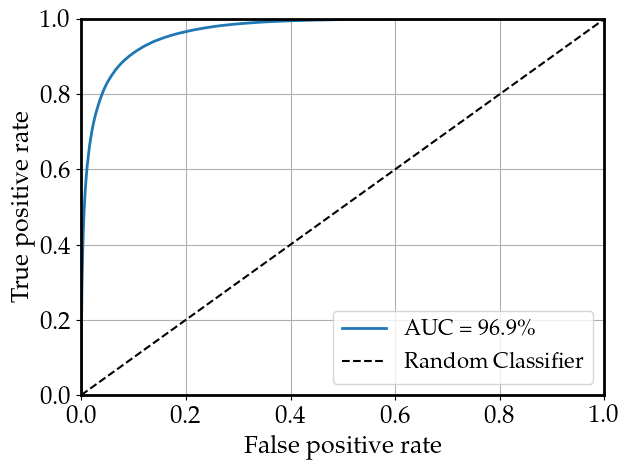

In [43]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_kinematics.pdf')
plt.show()

In [44]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_kinematics.pdf')

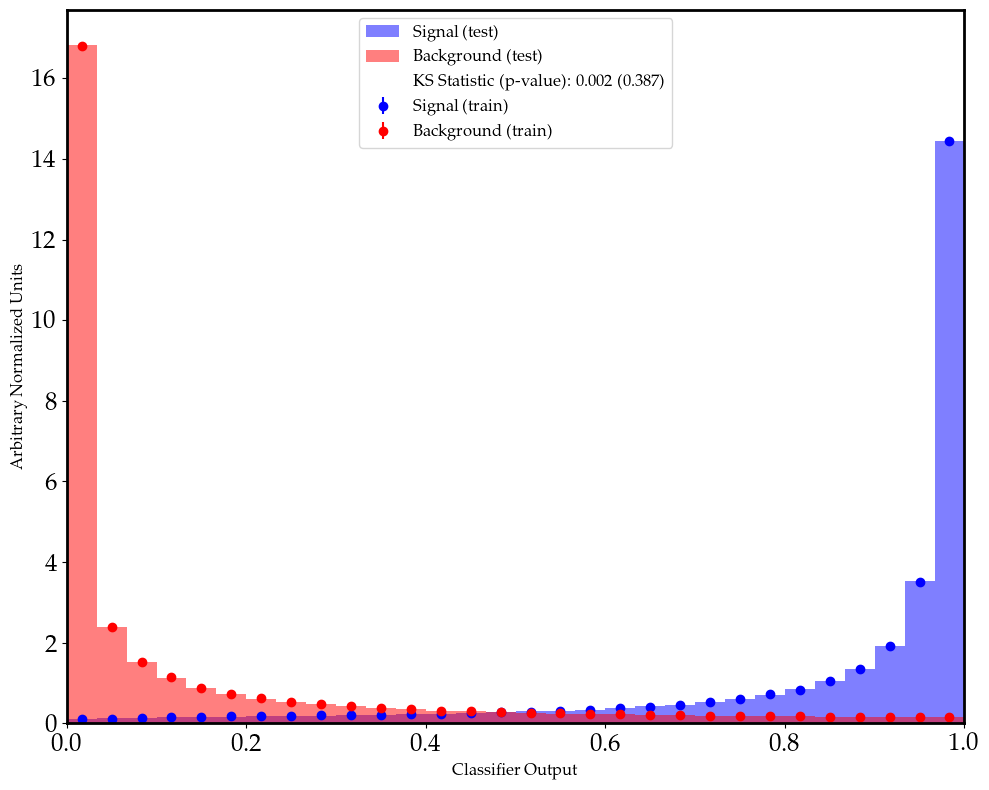

In [45]:
fig

In [46]:
bdt = XGBClassifier(booster='gbtree')

In [47]:
%%time
bdt.fit(X_train_final.to_numpy(), y_train.to_numpy())

CPU times: user 48min 8s, sys: 1min 10s, total: 49min 18s
Wall time: 5min 47s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [48]:
print(bdt.score(X_train_final.to_numpy(), y_train.to_numpy()))
print(bdt.score(X_test_final.to_numpy(), y_test.to_numpy()))

0.9041060893044136
0.9024365605301439


In [49]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

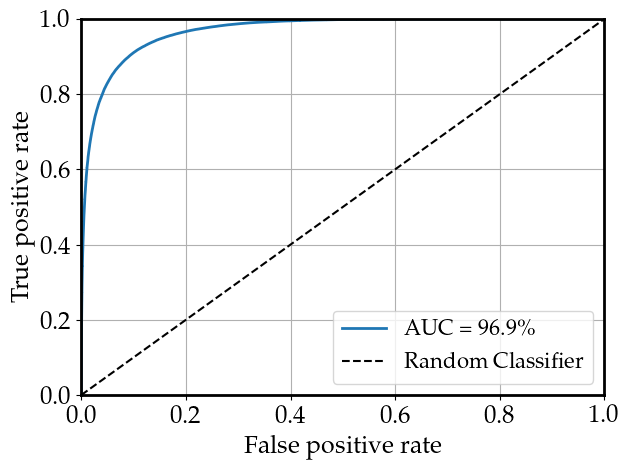

In [50]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_kinematics.pdf')
plt.show()

In [51]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_kinematics.pdf')

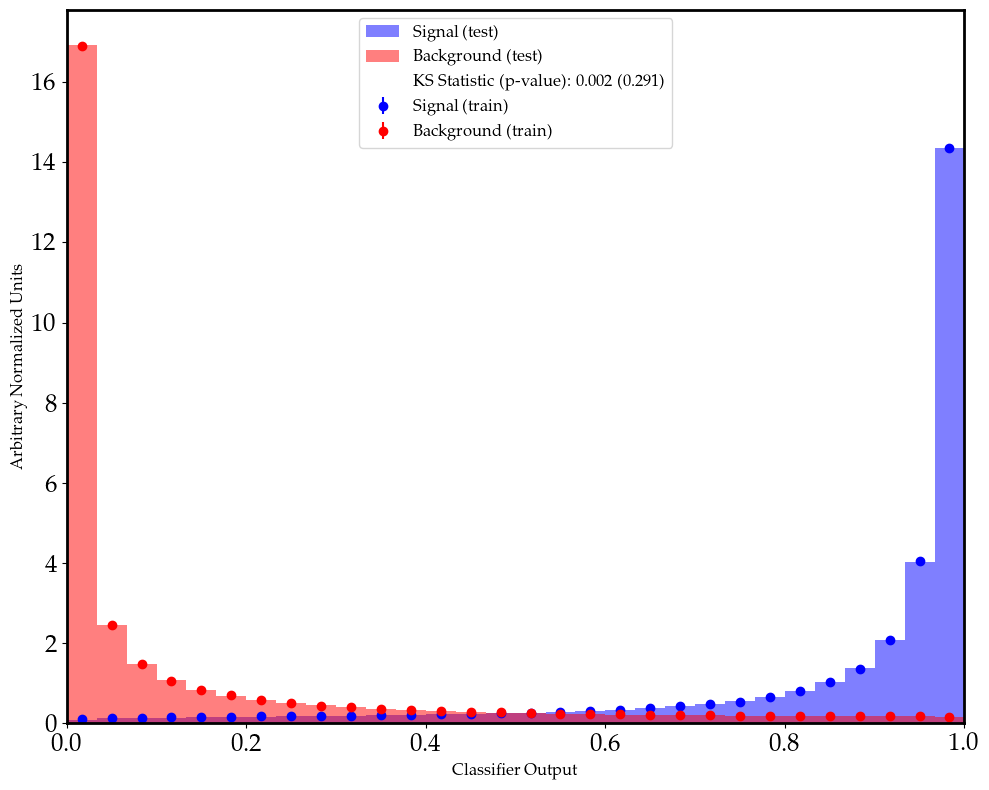

In [52]:
fig

In [53]:
fisher = LinearDiscriminantAnalysis()

In [54]:
%%time
fisher.fit(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

CPU times: user 6.69 s, sys: 1.39 s, total: 8.08 s
Wall time: 4.99 s


LinearDiscriminantAnalysis()

In [55]:
print(fisher.score(X_train_final.to_numpy(), y_train.to_numpy()[:,0]))
print(fisher.score(X_test_final.to_numpy(), y_test.to_numpy()[:,0]))

0.7591430428742176
0.7590849092182533


In [56]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,1])

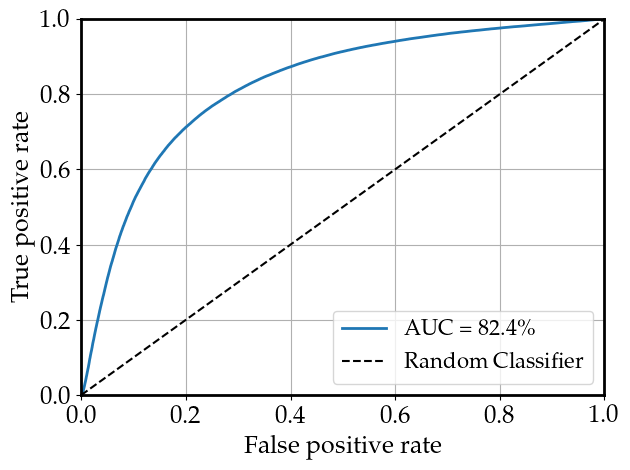

In [57]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_kinematics.pdf')
plt.show()

In [58]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,1],
                   y_test.to_numpy()[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_kinematics.pdf')

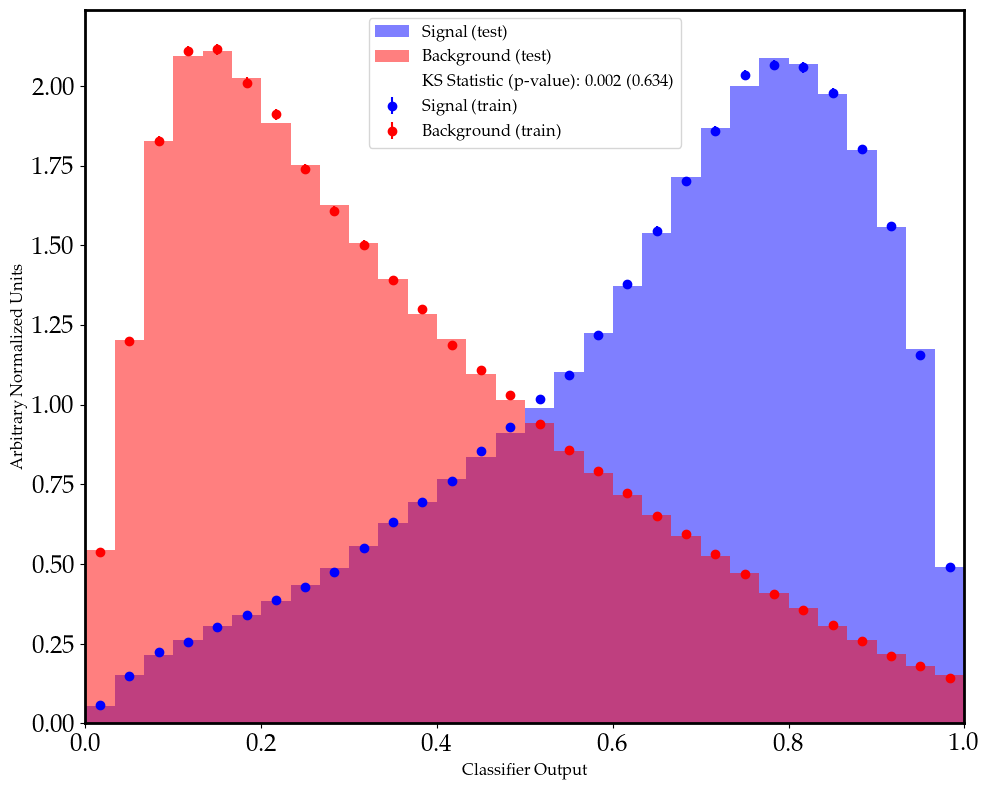

In [59]:
fig